In [1]:
'''Importing required libraries'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('max_columns', None)

In [2]:
'''Setting data path and reading the data'''
dataPath = 'data/'
fileName = 'data_example.csv'
filePath = dataPath+fileName
data = pd.read_csv(filePath)

Let's have a look at the read data

In [3]:
data.head()

unique_id      date_registered registration_platform marketing_source  \
0  105709319455  2020-01-01 00:03:29                   iOS          organic   
1  105709319456  2020-01-01 00:15:34               Android          organic   
2  105709319456  2020-01-01 00:15:34               Android          organic   
3  105709319456  2020-01-01 00:15:34               Android          organic   
4  105709319456  2020-01-01 00:15:34               Android          organic   

   lifetime_banchees_spent  lifetime_logindays  sessions_total  \
0                      0.0                   1               1   
1                      0.0                   5               1   
2                      0.0                   5               2   
3                      0.0                   5               3   
4                      0.0                   5               4   

  date_last_login  active_four_weeks  session_number  session_duration  \
0      2020-01-01              False               1               185   
1      2020-01-05              False               1              2289   
2      2020-01-05              False               2              2249   
3      2020-01-05              False               3                 4   
4      2020-01-05              False               4               404   

            first_date            last_date  max_points  transactions  \
0  2020-01-01 01:03:29  2020-01-01 01:06:34           0             0   
1  2020-01-01 01:15:34  2020-01-01 01:53:43         530             0   
2  2020-01-01 01:17:29  2020-01-01 01:54:58         530             0   
3  2020-01-01 01:47:18  2020-01-01 01:47:22         530             0   
4  2020-01-01 11:28:15  2020-01-01 11:34:59         566             0   

   eventcount_total  quest_closed  eventcount_message  eventcount_fight  \
0                 9             0                   0                 0   
1                42             0                   0                 0   
2                 7             0                   0                 0   
3                 3             0                   0                 0   
4                12             0                   0                 0   

   eventcount_trade  eventcount_build  eventcount_recruit  eventcount_ally  \
0                 0                 3                   0                0   
1                 0                20                   2                0   
2                 0                17                   2                0   
3                 0                 0                   0                0   
4                 0                 7                   0                0   

   eventcount_research  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

In [4]:
"""Checking total number of unique players"""
len(data['unique_id'].unique())

66720

The columns are as described in the problem description. For a `unique_id`, the `date_registered`, `registration_platform`, `marketing_source`, `lifetime_branchees_spent`, `lifetime_logindays` remain same irrespective session. Therefore, it makes sense to group the data by for these columns

In [5]:
np.all(data['session_number']==data['sessions_total'])

True

In [6]:
allColumns = list(data.columns)
groupByCols = ['unique_id','date_registered','registration_platform','marketing_source',\
                         'lifetime_banchees_spent','lifetime_logindays','active_four_weeks']

In [7]:
groupData = data.groupby(groupByCols)

In [8]:
''' Properties dependant upon the session of a user are listed'''
elementsToAnalyze = ['session_duration','max_points', 'transactions', 'eventcount_total', 'quest_closed',
                     'eventcount_message', 'eventcount_fight', 'eventcount_trade', 'eventcount_build', 
                     'eventcount_recruit', 'eventcount_ally', 'eventcount_research']

To analyse the user behaviour for first 30 sessions, the original data is grouped by `registration_platform` and `session_number`. This gives grouped information for each `session_number` per platform. An average of the attributes to be analyzed per session number, per platform is then calculated

In [9]:
analysis = data.groupby(['registration_platform', 'session_number'])[elementsToAnalyze].mean()

In [10]:
'''Writing out a plotting function'''

numToBeAnalysed = 30

def plotStuff(df, numToBeAnalysed, label=['session_duration','max_points'], platforms=['Android', 'iOS', 'Browser'],figsize=(8,8), save=False):
    f, axes = plt.subplots(nrows = len(label),figsize=figsize)
    for ax_i in range(len(label)):
        ax = axes[ax_i]
        ax.set_title(label[ax_i])
        for plf in platforms:
            data = df.xs([plf]).loc[1:numToBeAnalysed][label[ax_i]]
            p = ax.plot(data)
        ax.legend(platforms, loc=1)
        ax.yaxis.labelpad = 25
    f.tight_layout()
    
    if save:
        plt.savefig(label[0]+'.png')


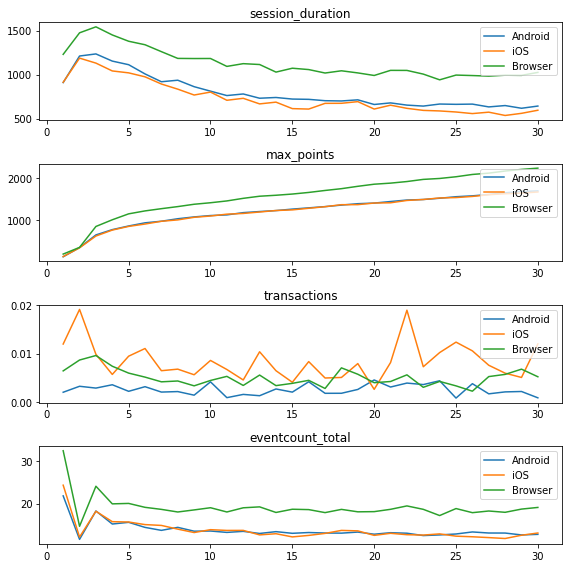

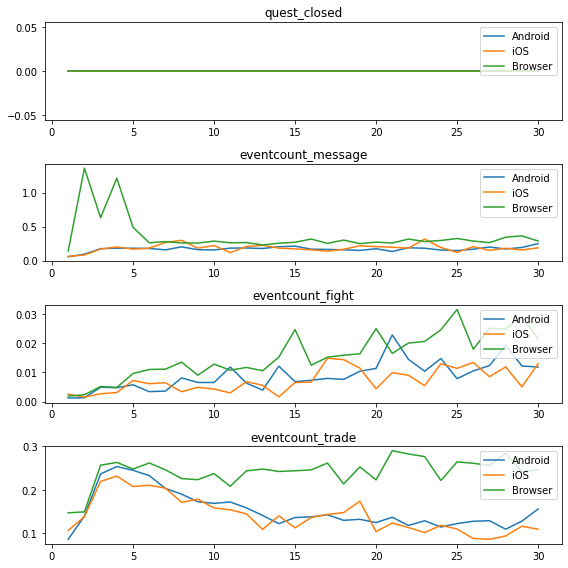

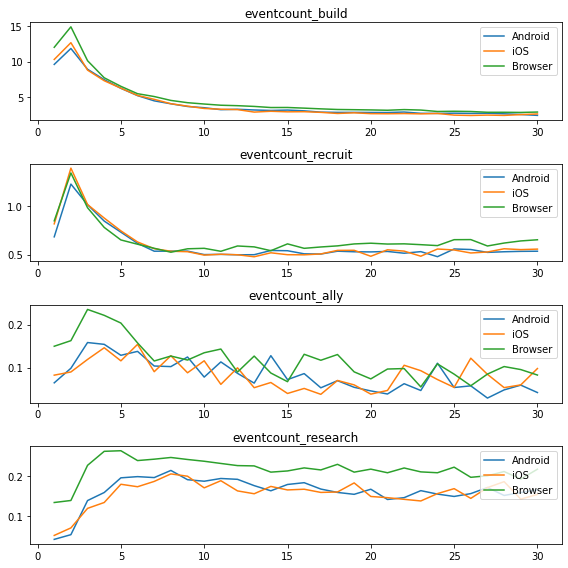

In [11]:
'''Plotting for all elements to be analyzed'''

nLabels = len(elementsToAnalyze)
nPlot = 4
for i in range(int(np.ceil(nLabels/nPlot))):
    plotStuff(analysis, 30, label=elementsToAnalyze[i*nPlot:(i+1)*nPlot], save=True)

What can be seen from the above plots is as follows:

- In general, the mean session duration for browser is higher than either of the apps 


- Maximum points, total event count, and individual event counts are generally more in browser than in apps. This could be since the session duration is longer, the player engagement is longer which leads to more event counts


- The mean session duration reduces gradually with increasing session number whereas the maximum points achieved increases. This could signify player's increasing familiarity or even advances in game leading to more points


- iOS users tend to conduct more transactions per session


- Total event counts are also higher for browser based users


- In earlier sessions, the amount of messages browser based players wrote is considerably high, but it reduced over time. Is it possible that because of having a keyboard and a larger typing setup, the browser based players found it easier to write texts. But reduced sending texts since it does not create much influence in the game?


- Amount of fights put up increases with increase number of sessions, maybe because it is required as one advances in the game


- All platform players traded resources in the beginning, but app based number of trades reduced over time whereas browser based didn't so much. Unlike messages, number of trades doesn't drop (for browser) which could mean that doing trades is important and influential. Is there need to improve at the trading interface in apps? 


- Recruit and Build orders went down over time for all platforms. Similar trend as session duration


- Ally interaction numbers are a bit noisy, cannot infer much about the user behaviour, but the trend seems to go rather down


- Research was really low in the beginning but then it increased and stayed to level. Still, the numbers are more for browser based users which might be also due to more session duration leading to more event counts

For performing churn analysis, categorical data like registration platform and marketing sources are one-hot encoded.

In [12]:
dataReform = groupData['sessions_total'].max().to_frame()
dataReform['sessions_total'] = dataReform['sessions_total'].apply(lambda x:min(x,numToBeAnalysed))
dataReform.reset_index(level=groupByCols[1:], inplace=True)
oneHotPlatform = pd.get_dummies(dataReform['registration_platform'],prefix='plt')
dataReform = dataReform.join(oneHotPlatform).drop(columns=['registration_platform'])
oneHotSource = pd.get_dummies(dataReform['marketing_source'],prefix='src')
dataReform = dataReform.join(oneHotSource).drop(columns=['marketing_source'])
dataReform.drop(columns=['date_registered'], inplace=True)

In [13]:
dataReform.head()

lifetime_banchees_spent  lifetime_logindays  active_four_weeks  \
unique_id                                                                      
105709319455                      0.0                   1              False   
105709319456                      0.0                   5              False   
105709319457                      0.0                   1              False   
105709319458                      0.0                   1              False   
105709319459                      0.0                   1              False   

              sessions_total  plt_Android  plt_Browser  plt_iOS  \
unique_id                                                         
105709319455               1            0            0        1   
105709319456              30            1            0        0   
105709319457               1            1            0        0   
105709319458               1            0            1        0   
105709319459               1            1            0        0   

              src_innogames/crm  src_marketing  src_organic  
unique_id                                                    
105709319455                  0              0            1  
105709319456                  0              0            1  
105709319457                  0              0            1  
105709319458                  1              0            0  
105709319459                  0              0            1

For session specific data of a particular player, a mean of each attribute for the a maximum of 30 sessions is calculated. 

In [14]:
sessWise = groupData[elementsToAnalyze].apply(lambda x:np.mean(x[:numToBeAnalysed]))
sessWise.reset_index(level=groupByCols[1:], inplace=True)
sessWise.drop(columns=groupByCols[1:], inplace=True)

In [15]:
sessWise.head()

session_duration  max_points  transactions  eventcount_total  \
unique_id                                                                    
105709319455        185.000000         0.0           0.0               9.0   
105709319456        593.366667       942.2           0.0              12.5   
105709319457         11.000000         0.0           0.0               4.0   
105709319458          8.000000         0.0           0.0               3.0   
105709319459        827.000000         0.0           0.0              25.0   

              quest_closed  eventcount_message  eventcount_fight  \
unique_id                                                          
105709319455           0.0                 0.0               0.0   
105709319456           0.0                 0.0               0.0   
105709319457           0.0                 0.0               0.0   
105709319458           0.0                 0.0               0.0   
105709319459           0.0                 0.0               0.0   

              eventcount_trade  eventcount_build  eventcount_recruit  \
unique_id                                                              
105709319455               0.0          3.000000            0.000000   
105709319456               0.0          4.133333            0.933333   
105709319457               0.0          0.000000            0.000000   
105709319458               0.0          0.000000            0.000000   
105709319459               0.0         11.000000            2.000000   

              eventcount_ally  eventcount_research  
unique_id                                           
105709319455         0.000000             0.000000  
105709319456         0.033333             0.133333  
105709319457         0.000000             0.000000  
105709319458         0.000000             0.000000  
105709319459         1.000000             0.000000

In [16]:
'''Join the player data with its mean session data'''
dataReform=dataReform.join(sessWise)

In [17]:
dataReform.head()

lifetime_banchees_spent  lifetime_logindays  active_four_weeks  \
unique_id                                                                      
105709319455                      0.0                   1              False   
105709319456                      0.0                   5              False   
105709319457                      0.0                   1              False   
105709319458                      0.0                   1              False   
105709319459                      0.0                   1              False   

              sessions_total  plt_Android  plt_Browser  plt_iOS  \
unique_id                                                         
105709319455               1            0            0        1   
105709319456              30            1            0        0   
105709319457               1            1            0        0   
105709319458               1            0            1        0   
105709319459               1            1            0        0   

              src_innogames/crm  src_marketing  src_organic  session_duration  \
unique_id                                                                       
105709319455                  0              0            1        185.000000   
105709319456                  0              0            1        593.366667   
105709319457                  0              0            1         11.000000   
105709319458                  1              0            0          8.000000   
105709319459                  0              0            1        827.000000   

              max_points  transactions  eventcount_total  quest_closed  \
unique_id                                                                
105709319455         0.0           0.0               9.0           0.0   
105709319456       942.2           0.0              12.5           0.0   
105709319457         0.0           0.0               4.0           0.0   
105709319458         0.0           0.0               3.0           0.0   
105709319459         0.0           0.0              25.0           0.0   

              eventcount_message  eventcount_fight  eventcount_trade  \
unique_id                                                              
105709319455                 0.0               0.0               0.0   
105709319456                 0.0               0.0               0.0   
105709319457                 0.0               0.0               0.0   
105709319458                 0.0               0.0               0.0   
105709319459                 0.0               0.0               0.0   

              eventcount_build  eventcount_recruit  eventcount_ally  \
unique_id                                                             
105709319455          3.000000            0.000000         0.000000   
105709319456          4.133333            0.933333         0.033333   
105709319457          0.000000            0.000000         0.000000   
105709319458          0.000000            0.000000         0.000000   
105709319459         11.000000            2.000000         1.000000   

              eventcount_research  
unique_id                          
105709319455             0.000000  
105709319456             0.133333  
105709319457             0.000000  
105709319458             0.000000  
105709319459             0.000000

For performing churn analysis, a decision tree model is chosen for classification. A grid search cross validation is performed in order to find out the best maximum tree depth

In [18]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

def gridSearch(X, y, model, parameters, cv=None, n_jobs=4):

    clf = GridSearchCV(model(), trainableParams, n_jobs=4, cv=cv)
    clf.fit(X=X, y=y)
    bestModel = clf.best_estimator_
    print (clf.best_score_, clf.best_params_)
    return bestModel, clf

def testTrain(X, y, model, testSize=0.33, randomState=108):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=randomState)
    accuracyTrain = model.score(X_train, y_train)
    accuracyTest = model.score(X_test, y_test)
    print("training accuracy: {} and testing accuracy: {}".format(accuracyTrain,accuracyTest))
    return (X_train, y_train), (X_test, y_test)

In [19]:
X = dataReform.drop(columns=['active_four_weeks'])
y = dataReform['active_four_weeks']
trainableParams = {'max_depth':range(3,10)}

bestModel,_ = gridSearch(X=X, y=y, model=tree.DecisionTreeClassifier, parameters=trainableParams)
(X_train, y_train),(X_test,y_test) = testTrain(X=X, y=y, model=bestModel)


0.9792116306954437 {'max_depth': 6}
training accuracy: 0.9817905239139189 and testing accuracy: 0.9805613588881824


The decision tree model was trained and the training & testing accuracy seem to be quite good. But this does not tell everything about a prediction. Therefore a normalized confusion matrix has been plotted for test data

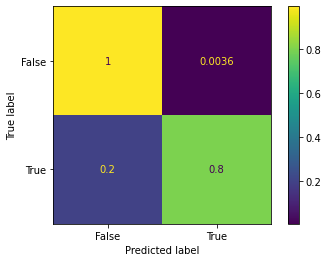

In [20]:
fig = plot_confusion_matrix(bestModel, X_test, y_test, normalize='true')
#plt.savefig('confmatrix.png')

The confusion matrix plotted above gives more information about the predictions preformed by the model. 

* True Positives = 0.8
* False Positives = 0.0036
* True Negatives = 0.9964
* False Negatives = 0.2

This states that with the given trained model, if a player is predicted to be True, then there is an 80% chance of a correct prediction. On the other hand, if a player is predicted to be False, it is 99.64% a right prediction